In [10]:
import tensorflow as tf
import numpy as np
import os
import pandas as pd
import glob
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

print("Libraries imported successfully.")

Libraries imported successfully.


In [13]:
# Unzip the dataset
!unzip -o -q /content/Data.zip -d /content/

# Set data path
data_path = '/content/Data/'
categories = [f for f in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, f))]
print(f"Detected categories: {categories}")

# Create lists for file paths and labels
X, y = [], []
for category in categories:
    path = os.path.join(data_path, category)
    for img in os.listdir(path):
        if img.endswith(('.jpg', '.jpeg', '.png')):
            X.append(os.path.join(path, img))
            y.append(category)

print(f"Total images found: {len(X)}")

Detected categories: ['Tulip', 'Sunflower']
Total images found: 200


In [14]:
# Split into 70% training and 30% validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=101)

# Create DataFrames
train_df = pd.DataFrame({'FileName': X_train, 'Category': y_train})
val_df = pd.DataFrame({'FileName': X_val, 'Category': y_val})

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")

Training samples: 140
Validation samples: 60


In [15]:
# Define augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2
)

# Only rescaling for validation (no augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_dataframe(
    train_df,
    x_col='FileName',
    y_col='Category',
    batch_size=32,
    class_mode='categorical',
    target_size=(224, 224)
)

validation_set = val_datagen.flow_from_dataframe(
    val_df,
    x_col='FileName',
    y_col='Category',
    batch_size=32,
    class_mode='categorical',
    target_size=(224, 224)
)

Found 140 validated image filenames belonging to 2 classes.
Found 60 validated image filenames belonging to 2 classes.


In [16]:
# Load VGG16 without the top classification layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained weights
for layer in base_model.layers:
    layer.trainable = False

# Build the custom model
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(categories), activation='softmax')
])

# Compile
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,137,986 (80.64 MB)

 Trainable params: 6,423,298 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [17]:
# Train the model
history = model.fit(
    training_set,
    validation_data=validation_set,
    epochs=10
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 139s 28s/step - accuracy: 0.6184 - loss: 0.7238 - val_accuracy: 0.8833 - val_loss: 0.4042
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 131s 27s/step - accuracy: 0.8561 - loss: 0.4015 - val_accuracy: 0.8833 - val_loss: 0.2955
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 128s 27s/step - accuracy: 0.8550 - loss: 0.3326 - val_accuracy: 0.8667 - val_loss: 0.2855
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 127s 27s/step - accuracy: 0.8896 - loss: 0.2634 - val_accuracy: 0.9167 - val_loss: 0.2307
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 187s 37s/step - accuracy: 0.9736 - loss: 0.1608 - val_accuracy: 0.9167 - val_loss: 0.2137
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 129s 27s/step - accuracy: 0.9313 - loss: 0.1890 - val_accuracy: 0.8667 - val_loss: 0.2507
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 126s 27s/step - accuracy: 0.9473 - loss: 0.1437 - val_accuracy: 0.9167 - val_loss: 0.1950
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 126s 27s/step - accuracy: 0.9753 - loss: 0.1356 - val_accuracy: 0.9167 - val_loss:

In [18]:
# Update this path to an actual image file in your directory
test_img_path = X_val[0]

img = image.load_img(test_img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions)
predicted_class = categories[predicted_class_index]

print(f"Predicted Class: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step
Predicted Class: Sunflower


In [25]:
loss, accuracy = model.evaluate(validation_set)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 40s 17s/step - accuracy: 0.9236 - loss: 0.1718
Test Loss: 0.1710
Test Accuracy: 0.9167


In [20]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Re-create the validation generator WITHOUT shuffling
test_set = val_datagen.flow_from_dataframe(
    val_df,
    x_col='FileName',
    y_col='Category',
    batch_size=32,
    class_mode='categorical',
    target_size=(224, 224),
    shuffle=False  # Crucial for the report!
)

# 2. Get the raw predictions (probabilities)
Y_pred = model.predict(test_set)

# 3. Convert probabilities to class indices (0 or 1)
y_pred = np.argmax(Y_pred, axis=1)

# 4. Get the true labels from the generator
y_true = test_set.classes

# 5. Get the class names (Sunflower, Tulip)
target_names = list(test_set.class_indices.keys())

Found 60 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 54s 19s/step


In [23]:
print('Classification Report')
print(classification_report(y_true, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

   Sunflower       0.92      0.89      0.91        27
       Tulip       0.91      0.94      0.93        33

    accuracy                           0.92        60
   macro avg       0.92      0.91      0.92        60
weighted avg       0.92      0.92      0.92        60



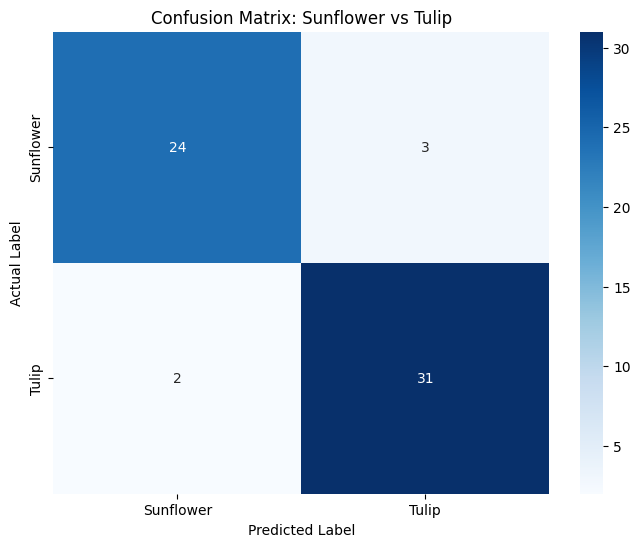

In [24]:
# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names)
plt.title('Confusion Matrix: Sunflower vs Tulip')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

In [27]:
import pandas as pd
from IPython.display import HTML

# 1. Create a function to convert image paths to HTML <img> tags
def image_formatter(path):
    return f'<img src="{path}" width="100">'

# 2. Get the file paths and actual labels from the test_set generator
test_images = test_set.filepaths
true_labels = [target_names[i] for i in test_set.classes]

# 3. Create a DataFrame with the results
results_df = pd.DataFrame({
    'Image': test_images,
    'Actual Label': true_labels,
    'Predicted Label': [target_names[i] for i in y_pred],
})

# 4. Add a column to see if the prediction was correct
# This helps you quickly spot where the model failed
results_df['Status'] = results_df.apply(
    lambda x: '✅ Correct' if x['Actual Label'] == x['Predicted Label'] else '❌ Wrong',
    axis=1
)

# 5. Display the DataFrame with images rendered
print(f"Displaying results for {len(results_df)} images:")
HTML(results_df.to_html(formatters={'Image': image_formatter}, escape=False, index=False))

Displaying results for 60 images:


Image,Actual Label,Predicted Label,Status
,Tulip,Tulip,✅ Correct
,Sunflower,Sunflower,✅ Correct
,Tulip,Tulip,✅ Correct
,Tulip,Tulip,✅ Correct
,Tulip,Tulip,✅ Correct
,Sunflower,Sunflower,✅ Correct
,Tulip,Tulip,✅ Correct
,Tulip,Tulip,✅ Correct
,Sunflower,Sunflower,✅ Correct
,Sunflower,Sunflower,✅ Correct


Displaying results for 60 images:


Image_HTML,Actual Label,Predicted Label,Status
,Tulip,Tulip,✅ Correct
,Sunflower,Sunflower,✅ Correct
,Tulip,Tulip,✅ Correct
,Tulip,Tulip,✅ Correct
,Tulip,Tulip,✅ Correct
,Sunflower,Sunflower,✅ Correct
,Tulip,Tulip,✅ Correct
,Tulip,Tulip,✅ Correct
,Sunflower,Sunflower,✅ Correct
,Sunflower,Sunflower,✅ Correct

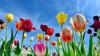
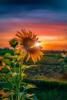
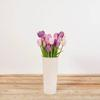
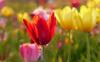
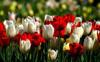
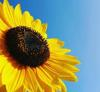
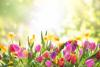
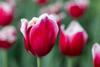
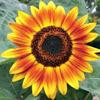
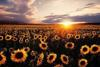
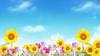
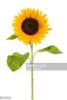
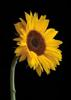
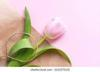
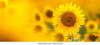
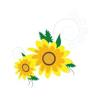
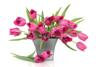
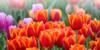
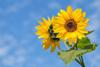
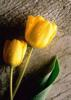
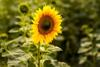
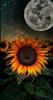
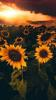
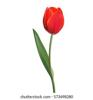
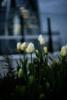
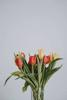
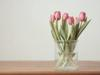
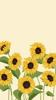
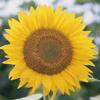
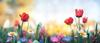
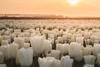
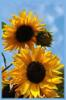
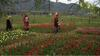
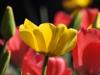
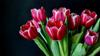
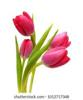
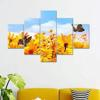
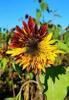
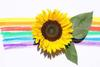
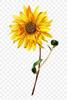
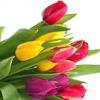
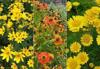
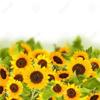
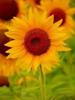
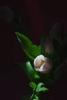
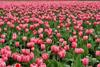
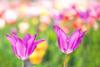
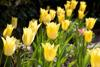
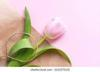
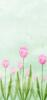
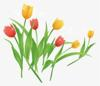
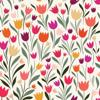
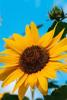
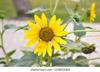
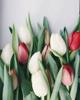
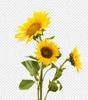
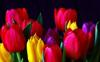
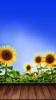
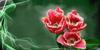
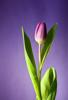

In [28]:
import pandas as pd
from IPython.display import HTML
import base64
from io import BytesIO
from PIL import Image

# 1. Function to convert image file to a Base64 string
def get_thumbnail(path):
    try:
        img = Image.open(path)
        img.thumbnail((100, 100)) # Resize for the table
        buffered = BytesIO()
        img.save(buffered, format="JPEG")
        encoded_string = base64.b64encode(buffered.getvalue()).decode()
        return f'<img src="data:image/jpeg;base64,{encoded_string}" width="100">'
    except:
        return "Image not found"

# 2. Get the file paths and actual labels
test_images = test_set.filepaths
true_labels = [target_names[i] for i in test_set.classes]

# 3. Create a DataFrame
results_df = pd.DataFrame({
    'Image': test_images,
    'Actual Label': true_labels,
    'Predicted Label': [target_names[i] for i in y_pred],
})

# 4. Add Status column
results_df['Status'] = results_df.apply(
    lambda x: '✅ Correct' if x['Actual Label'] == x['Predicted Label'] else '❌ Wrong',
    axis=1
)

# 5. Apply the Base64 formatter to the Image column
results_df['Image_HTML'] = results_df['Image'].map(get_thumbnail)

# 6. Display the new Column (Image_HTML) instead of the path
# We select the columns we want to show
display_df = results_df[['Image_HTML', 'Actual Label', 'Predicted Label', 'Status']]

print(f"Displaying results for {len(display_df)} images:")
HTML(display_df.to_html(escape=False, index=False))